# BERT

In [1]:
import re
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

## 1. Data

In [2]:
import datasets

dataset = datasets.load_dataset("swag", "regular", split={"train": "train", "validation": "validation"})
dataset = dataset.remove_columns(['video-id', 'fold-ind', 'sent1', 'sent2', 'gold-source'])  # remove all irrelavant fields as we will not be using them in our task

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['startphrase', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 73546
    })
    validation: Dataset({
        features: ['startphrase', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20006
    })
})

In [4]:
# Let's check the first startphrase and the true ending
print(f"Start Phrase: {dataset['train']['startphrase'][0]}")
print(f"True Ending: {dataset['train']['ending0'][0]}")
print(f"Label: {dataset['train']['label'][0]}")

Start Phrase: Members of the procession walk down the street holding small horn brass instruments. A drum line
True Ending: passes by walking down the street playing their instruments.
Label: 0


## 2. Preprocessing

### Tokenization and numericalization

In [5]:
import random

def transform_data(example):
    start = re.sub("[.,!?\\-]", '', example['startphrase'].lower())
    true_label = example['label']

    if np.random.random() < 0.5:
        ending = re.sub("[.,!?\\-]", '', example[f'ending{true_label}'].lower())
        return {'start': start,
                'ending': ending,
                'isNext': True}
    else:
        ending_choice = [0, 1, 2, 3]
        ending_choice.remove(true_label)
        ending = re.sub("[.,!?\\-]", '', example[f'ending{random.choice(ending_choice)}'].lower())
        return {'start': start,
                'ending': ending,
                'isNext': False}
    
transformed_dataset = dataset.map(transform_data, remove_columns=['startphrase', 'ending0', 'ending1', 'ending2', 'ending3', 'label'])

In [6]:
import torchtext

# load the 'basic_english' tokenizer (other tokenizers can also be used such as 'spacy' and 'subword')
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

# create another field called 'tokens' which contains list of tokens
tokenize_data = lambda example, tokenizer: {k+'_tokens': tokenizer(v) for (k,v) in example.items() if k != 'isNext'}
tokenized_dataset = transformed_dataset.map(tokenize_data, remove_columns=['start', 'ending'], fn_kwargs={'tokenizer': tokenizer})

In [7]:
vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_dataset['train']['start_tokens']+tokenized_dataset['train']['ending_tokens']
)
vocab.insert_token('[PAD]', 0)
vocab.insert_token('[CLS]', 1)
vocab.insert_token('[SEP]', 2)
vocab.insert_token('[MASK]', 3)
vocab.insert_token('[UNK]', 4)
vocab.set_default_index(vocab['[UNK]'])

# save vocab_transform
torch.save(vocab, './model/vocab')

## 3. Data loader

We gonna make dataloader.  Inside here, we need to make two types of embeddings: **token embedding** and **segment embedding**

1. **Token embedding** - Given “The cat is walking. The dog is barking”, we add [CLS] and [SEP] >> “[CLS] the cat is walking [SEP] the dog is barking”. 

2. **Segment embedding**
A segment embedding separates two sentences, i.e., [0 0 0 0 1 1 1 1 ]

3. **Masking**
As mentioned in the original paper, BERT randomly assigns masks to 15% of the sequence. In this 15%, 80% is replaced with masks, while 10% is replaced with random tokens, and the rest 10% is left as is.  Here we specified `max_pred` 

4. **Padding**
Once we mask, we will add padding. For simplicity, here we padded until some specified `max_len`. 

Note:  `positive` and `negative` are just simply counts to keep track of the batch size.  `positive` refers to two sentences that are really next to one another.

In [8]:
from tqdm import tqdm

def get_data(dataset, vocab, max_mask, max_len):
    data = []
    
    for example in tqdm(dataset):
        # transform the list of tokens to list of token's indices based on our vocab
        tokens_a = [vocab[token] for token in example['start_tokens']]
        tokens_b = [vocab[token] for token in example['ending_tokens']]

        #1. token embedding - add CLS and SEP
        input_ids = [vocab['[CLS]']] + tokens_a + [vocab['[SEP]']] + tokens_b + [vocab['[SEP]']]

        #2. segment embedding - which sentence is 0 and 1
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        n_pred = min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        #get all the pos excluding CLS and SEP
        candidates_masked_pos = [i for i, token in enumerate(input_ids) if token != vocab['[CLS]'] 
                                 and token != vocab['[SEP]']]
        np.random.shuffle(candidates_masked_pos)
        masked_tokens, masked_pos = [], []

        #simply loop and mask accordingly
        for pos in candidates_masked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            rand_val = np.random.random()
            if rand_val < 0.1:  #10% replace with random token
                index = np.random.randint(5, len(vocab) - 1)  # random token should not involve [PAD], [CLS], [SEP], [MASK], [UNK]
                input_ids[pos] = vocab[vocab.get_itos()[index]]
            elif rand_val < 0.8:  #80 replace with [MASK]
                input_ids[pos] = vocab['[MASK]']
            else: 
                pass

        #4. pad the sentence to the max length
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        #5. pad the mask tokens to the max length
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        instance = [input_ids, segment_ids, masked_tokens, masked_pos, [example['isNext']]]
        instance = [torch.LongTensor(i) for i in instance]
        data.append(instance)
        
    return data

In [9]:
batch_size = 16
max_mask   = 5  #even though it does not reach 15% yet....maybe you can set this threshold
max_len    = 512  #maximum length that my transformer will accept.....all sentence will be padded

In [10]:
train_data = get_data(tokenized_dataset['train'], vocab, max_mask, max_len)
val_data = get_data(tokenized_dataset['validation'], vocab, max_mask, max_len)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

100%|██████████| 20006/20006 [00:07<00:00, 2660.78it/s]


In [11]:
for input_ids, segment_ids, masked_tokens, masked_pos, isNext in train_loader:
    break

In [12]:
input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, isNext

(torch.Size([16, 512]),
 torch.Size([16, 512]),
 torch.Size([16, 5]),
 torch.Size([16, 5]),
 tensor([[0],
         [1],
         [1],
         [1],
         [1],
         [1],
         [0],
         [0],
         [0],
         [1],
         [0],
         [1],
         [0],
         [0],
         [1],
         [0]]))

## 4. Model

Recall that BERT only uses the encoder.

BERT has the following components:

- Embedding layers
- Attention Mask
- Encoder layer
- Multi-head attention
- Scaled dot product attention
- Position-wise feed-forward network
- BERT (assembling all the components)

## 4.1 Embedding

In [13]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        #x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

## 4.2 Attention mask

In [14]:
def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

### Testing the attention mask

In [15]:
print(get_attn_pad_mask(input_ids, input_ids, 'cpu').shape)

torch.Size([16, 512, 512])


## 4.3 Encoder

The encoder has two main components: 

- Multi-head Attention
- Position-wise feed-forward network

First let's make the wrapper called `EncoderLayer`

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn       = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

Let's define the scaled dot attention, to be used inside the multihead attention

In [17]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

Here is the Multiheadattention.

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        self.device = device
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(self.n_heads * self.d_v, self.d_model, device=self.device)(context)
        return nn.LayerNorm(self.d_model, device=self.device)(output + residual), attn # output: [batch_size x len_q x d_model]

Here is the PoswiseFeedForwardNet.

In [19]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))

## 4.4 Putting them together

In [20]:
class BERT(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device):
        super(BERT, self).__init__()
        self.params = {'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
                       'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
                       'vocab_size': vocab_size, 'max_len': max_len}
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        
        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_nsp
    
    def get_last_hidden_state(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        return output

## 5. Training

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


Let's define the parameters first

In [22]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

In [23]:
from tqdm import tqdm

model = BERT(n_layers, n_heads, d_model, d_ff, d_k, n_segments, len(vocab), max_len, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)  # BERT paper used 5e-5

In [24]:
def train(model, data, optimizer, criterion, device):
    epoch_loss = []
    model.train()

    for input_ids, segment_ids, masked_tokens, masked_pos, isNext in tqdm(data, desc='Training: '):
        optimizer.zero_grad()
        input_ids = input_ids.to(device)
        segment_ids = segment_ids.to(device)
        masked_tokens = masked_tokens.to(device)
        masked_pos = masked_pos.to(device)
        isNext = isNext.flatten().to(device)
        logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)    
        #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
        #logits_nsp: (bs, yes/no) ==> (6, 2)

        #1. mlm loss
        #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
        loss_lm = (loss_lm.float()).mean()
        #2. nsp loss
        #logits_nsp: (bs, 2) vs. isNext: (bs, )
        loss_nsp = criterion(logits_nsp, isNext) # for sentence classification
        
        #3. combine loss
        loss = loss_lm + loss_nsp
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    return np.mean(epoch_loss)

In [25]:
def evaluate(model, data, criterion, device):
    epoch_loss = []
    model.eval()

    with torch.no_grad():  # set the 'requires_grad' to False to speed up computation and reduce memory cost
        for input_ids, segment_ids, masked_tokens, masked_pos, isNext in tqdm(data, desc='Evaluate: '):
            input_ids = input_ids.to(device)
            segment_ids = segment_ids.to(device)
            masked_tokens = masked_tokens.to(device)
            masked_pos = masked_pos.to(device)
            isNext = isNext.flatten().to(device)
            logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)    
            #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
            #logits_nsp: (bs, yes/no) ==> (6, 2)

            #1. mlm loss
            #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
            loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
            loss_lm = (loss_lm.float()).mean()
            #2. nsp loss
            #logits_nsp: (bs, 2) vs. isNext: (bs, )
            loss_nsp = criterion(logits_nsp, isNext) # for sentence classification
            
            #3. combine loss
            loss = loss_lm + loss_nsp
            epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
save_path = './model/bert.pt'
num_epoch = 10

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epoch):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    lr_scheduler.step(val_loss)

    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model only when its validation loss is lower than all its predecessors
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save([model.params, model.state_dict()], save_path)  # save the model's parameters and state to a file

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}')

Evaluate: 100%|██████████| 1251/1251 [01:19<00:00, 15.72it/s]


Epoch: 01 | Time: 14m 18s
	Train Loss: 12.091
	 Val. Loss: 7.560


Evaluate: 100%|██████████| 1251/1251 [01:19<00:00, 15.71it/s]


Epoch: 02 | Time: 14m 35s
	Train Loss: 6.389
	 Val. Loss: 6.093


Evaluate: 100%|██████████| 1251/1251 [01:19<00:00, 15.80it/s]


Epoch: 03 | Time: 14m 15s
	Train Loss: 5.475
	 Val. Loss: 5.619


Evaluate: 100%|██████████| 1251/1251 [01:20<00:00, 15.59it/s]


Epoch: 04 | Time: 14m 22s
	Train Loss: 5.074
	 Val. Loss: 5.353


Evaluate: 100%|██████████| 1251/1251 [01:19<00:00, 15.65it/s]


Epoch: 05 | Time: 14m 22s
	Train Loss: 4.838
	 Val. Loss: 5.234


Evaluate: 100%|██████████| 1251/1251 [01:20<00:00, 15.61it/s]


Epoch: 06 | Time: 14m 24s
	Train Loss: 4.667
	 Val. Loss: 5.144


Evaluate: 100%|██████████| 1251/1251 [01:19<00:00, 15.67it/s]


Epoch: 07 | Time: 14m 24s
	Train Loss: 4.514
	 Val. Loss: 5.113


Evaluate: 100%|██████████| 1251/1251 [01:19<00:00, 15.67it/s]


Epoch: 08 | Time: 14m 20s
	Train Loss: 4.369
	 Val. Loss: 5.106


Evaluate: 100%|██████████| 1251/1251 [01:19<00:00, 15.67it/s]


Epoch: 09 | Time: 14m 21s
	Train Loss: 4.261
	 Val. Loss: 5.100


Evaluate: 100%|██████████| 1251/1251 [01:20<00:00, 15.63it/s]

Epoch: 10 | Time: 14m 22s
	Train Loss: 4.168
	 Val. Loss: 5.168


Text(0, 0.5, 'loss')

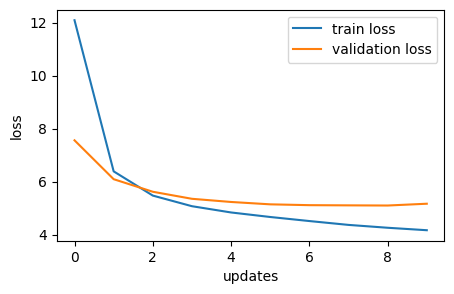

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'validation loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## 6. Inference

Since our dataset is very small, it won't work very well, but just for the sake of demonstration.

In [29]:
# load the model and all its hyperparameters
params, state = torch.load(save_path)
model = BERT(**params, device=device).to(device)
model.load_state_dict(state)

<All keys matched successfully>

In [34]:
# Predict mask tokens ans isNext
for input_ids, segment_ids, masked_tokens, masked_pos, isNext in val_loader:
    break

idx = 2
input_ids = input_ids[idx].reshape(1, -1).to(device)
segment_ids = segment_ids[idx].reshape(1, -1).to(device)
masked_tokens = masked_tokens[idx].reshape(1, -1).to(device)
masked_pos = masked_pos[idx].reshape(1, -1).to(device)
isNext = isNext[idx].item()

print([vocab.get_itos()[w.item()] for w in input_ids[0] if vocab.get_itos()[w.item()] != '[PAD]'])

logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
#logits_lm:  (1, max_mask, vocab_size) ==> (1, 5, 34)
#logits_nsp: (1, yes/no) ==> (1, 2)

#predict masked tokens
#max the probability along the vocab dim (2), [1] is the indices of the max, and [0] is the first value
logits_lm = logits_lm.data.cpu().max(2)[1][0].data.numpy() 
#note that zero is padding we add to the masked_tokens
print('masked tokens (words) : ',[vocab.get_itos()[pos.item()] for pos in masked_tokens[0] if pos.item() != 0])
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
print('predicted masked tokens (words) : ',[vocab.get_itos()[pos.item()] for pos in logits_lm if pos.item() != 0])
print('predicted masked tokens list : ', [pos for pos in logits_lm if pos.item() != 0])

#predict nsp
logits_nsp = logits_nsp.data.cpu().max(1)[1][0].data.numpy()
print(logits_nsp)
print('isNext : ', True if isNext else False)
print('predict isNext : ', True if logits_nsp else False)

['[CLS]', 'the', '[UNK]', 'gets', '[MASK]', 'of', 'bed', 'and', 'prepares', 'coffe', 'leave', 'by', 'bathing', '[MASK]', 'the', 'bathroom', 'and', 'reading', 'the', 'newspaper', 'he', '[SEP]', 'rides', 'the', 'motorcycle', 'down', 'the', 'hall', 'and', 'into', 'the', '[MASK]', '[SEP]']
masked tokens (words) :  ['out', 'using', 'to', 'elevator', 'reading']
masked tokens list :  [32, 197, 9, 828, 889]
predicted masked tokens (words) :  ['to', 'the', 'giving', 'to', 'reading']
predicted masked tokens list :  [9, 5, 965, 9, 889]
1
isNext :  True
predict isNext :  True
